In [1]:
%pip install pykan
%pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
from kan import *
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

In [3]:
device = 'cpu'

In [4]:
def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

In [5]:
dim = 2
np_i = 21 # number of interior points (along each dimension)
np_b = 21 # number of boundary points (along each dimension)
ranges = [-1, 1]

model = KAN(width=[2,2,1], grid=5, k=3, seed=1, device=device)

# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])

checkpoint directory created: ./model
saving model version 0.0


In [6]:
x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
x_i = torch.rand((np_i**2,2))*2-1
x_i = x_i.to(device)

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

x_b = x_b.to(device)

steps = 20
alpha = 0.01
log = 1

In [7]:
def train():
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

train()

pde loss: 2.09e+00 | bc loss: 8.24e-03 | l2: 4.25e-03 : 100%|███████| 20/20 [00:34<00:00,  1.72s/it]


Regression model


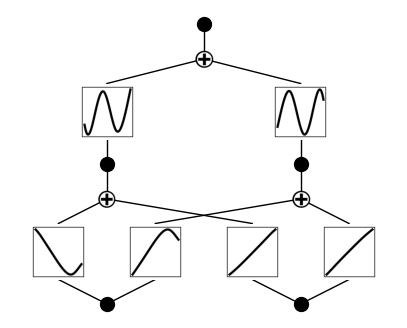

In [8]:
print(f"Regression model")
model.plot(beta=10)

In [9]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9974484443664551, c=2
fixing (0,0,1) with sin, r2=0.9974961280822754, c=2
fixing (0,1,0) with x, r2=0.9996017813682556, c=1
fixing (0,1,1) with sin, r2=0.9999815225601196, c=2
fixing (1,0,0) with x, r2=0.00021373512572608888, c=1
fixing (1,1,0) with x, r2=0.00028228358132764697, c=1
saving model version 0.1


Symbolic regression model


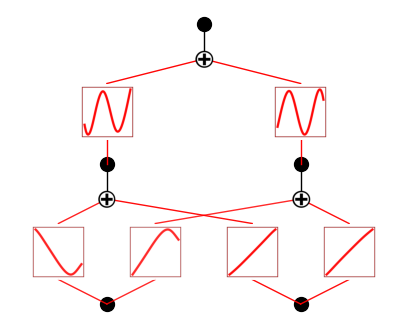

In [10]:
print(f"Symbolic regression model")
model.plot()

In [11]:
print(f"Symbolic formula")
ex_round(model.symbolic_formula()[0][0],2)

Symbolic formula


-0.e-2*x_2 + 0.01*sin(1.8*x_1 + 3.78) - 0.e-2*sin(1.85*x_1 - 8.82) - 0.02*sin(0.44*x_2 - 6.02) + 0.04